# Quora pair question

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
df=pd.read_csv("data/train.csv")

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.shape

(404290, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

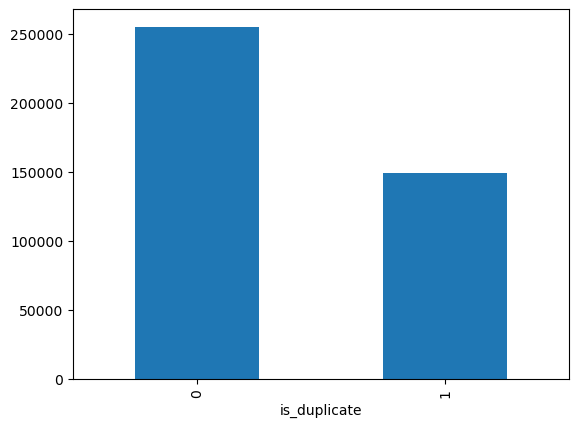

In [6]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [16]:
print("~> Question pairs are not similar (is_duplicate=0):", round((len(df[df['is_duplicate'] == 0]) / df.shape[0])*100,2))
print("~> Question pairs are  similar (is_duplicate=1):", round((len(df[df['is_duplicate'] == 1]) / df.shape[0])*100,2))

~> Question pairs are not similar (is_duplicate=0): 63.08
~> Question pairs are  similar (is_duplicate=1): 36.92


In [4]:
total_ques=pd.Series(df.qid1.tolist()+df.qid2.tolist())
unique_qids=len(np.unique(total_ques))
qs_more_than_one_time=np.sum(total_ques.value_counts()>1)
 
print("Total unique questions: ",unique_qids)
print("Questions present more than one: {} ({}%)".format(qs_more_than_one_time,qs_more_than_one_time/unique_qids))
print("Max ties a question is asked: ",np.max(total_ques.value_counts()))

Total unique questions:  537933
Questions present more than one: 111780 (0.20779539459375052%)
Max ties a question is asked:  157


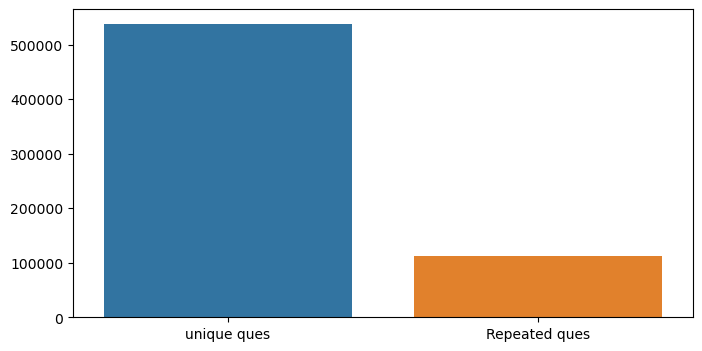

In [31]:
plt.figure(figsize=(8, 4))
sns.barplot(y=[unique_qids,qs_more_than_one_time],x=["unique ques","Repeated ques"])
plt.show();

### check for duplicates

In [41]:
gp=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2'])
print("duplicated rows are: ",gp.count().shape[0]-df.shape[0])

duplicated rows are:  0


## No of occurence of each question

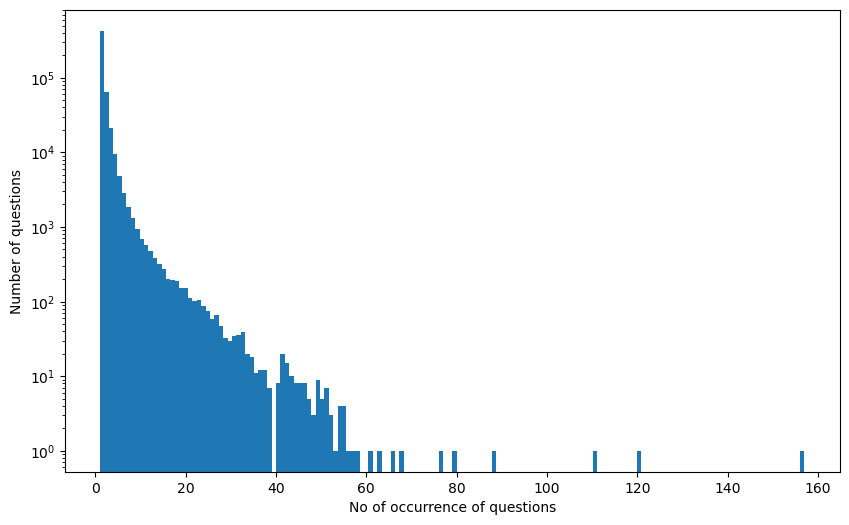

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(total_ques.value_counts(), bins=160)
plt.yscale("log")
# plt.yscale("log", nonposy='clip')  # Apply nonposy to the yscale
plt.xlabel("No of occurrence of questions")
plt.ylabel("Number of questions")
plt.show()


## checking for null values

In [50]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows,"\n\n")
print("total null rows: ",len(nan_rows))

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0   


total null rows:  3


C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_16200\1150155817.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = df[df.isnull().any(1)]


In [4]:
df=df.fillna(" ")
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_11228\591846037.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows=df[df.isnull().any(1)]


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1_len, q2_len]
Index: []


## Basic feature extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [5]:
total_ques

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64

In [8]:
df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


In [11]:
if os.path.isfile("data/df_fe_before_prepro_train.csv"):
    print("already present....")
else:
    df["freq_qid1"]=df.groupby(by="qid1")["qid1"].transform('count')
    df["freq_qid2"]=df.groupby("qid2")["qid2"].transform('count')
    df["q1_len"]=df["question1"].str.len()
    df["q2_len"]=df["question2"].str.len()
    df["q1_n_words"]=df["question1"].apply(lambda row: len(row.split(" ")))
    df["q2_n_words"]=df["question2"].apply(lambda row: len(row.split(" ")))
    
    
    def normalized_common_words(row):
        w1=set(map(lambda word: word.lower().strip(),row["question1"].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row["question2"].split(" ")))
        return 1.0*len(w1&w2)
    df["word_Common"]=df.apply(normalized_common_words,axis=1) 
    
    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)
    df["word_share "]=df["word_Common"]/ df["word_Total"]
    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)
    
    df.head()

In [12]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1_len,q2_len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [16]:
df.rename(columns={"word_share ": 'word_share'}, inplace=True)

### Analysis of extracted features

In [20]:
print("Minimum length of question in question1 : ",min(df["q1_n_words"]))
print("Minimum length of question in question2 : ",min(df["q2_n_words"]))
print("Maximum length of question in question1 : ",max(df["q1_n_words"]))
print("Maximum length of question in question2 : ",max(df["q2_n_words"]))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of question in question1 :  1
Minimum length of question in question2 :  1
Maximum length of question in question1 :  125
Maximum length of question in question2 :  237
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


__feature__ : word_share

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_11228\3057988603.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label="1", color='red')
C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_11228\3057988603.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

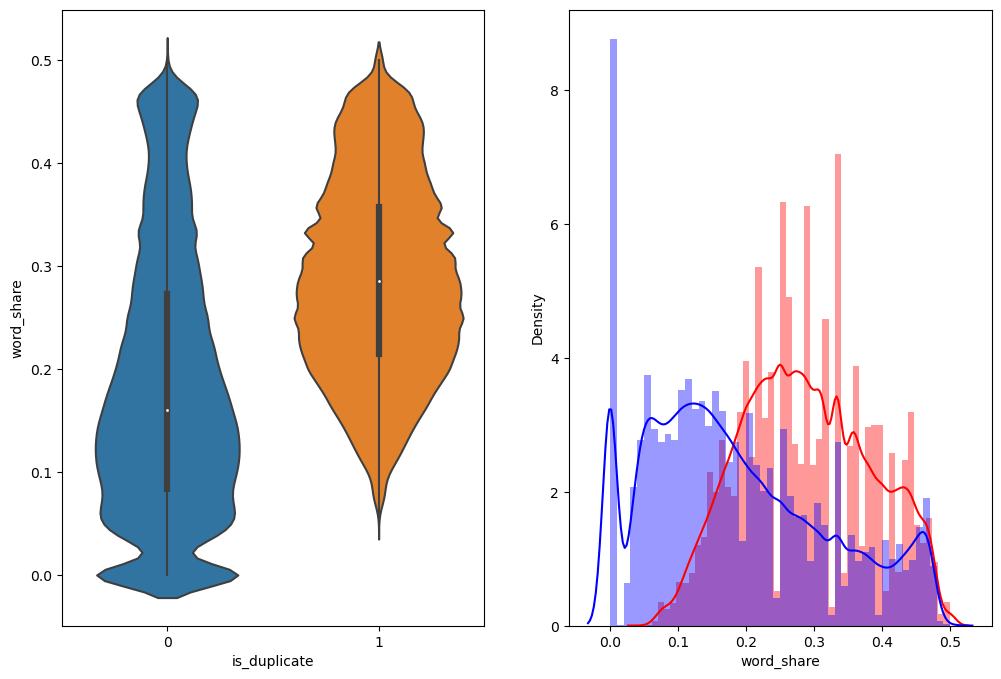

In [22]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df)
# sns.kdeplot(data=df[df["is_duplicate"]==0]["word_share"],color='blue',shade=True)
# sns.kdeplot(data=df[df["is_duplicate"]==1]["word_share"],color='green',shade=True)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'], label="1", color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'], label="0", color='blue')

plt.show();

- the distribution of normalized common words have overlap on right side (lots of questions have high similare words)
- the avg word share is more in case of duplicate questions

__feature__ :word_common

C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_11228\713384960.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["is_duplicate"]==1.0]["word_Common"],label="1",color="red")
C:\Users\Prashant Dahiya\AppData\Local\Temp\ipykernel_11228\713384960.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

<Axes: xlabel='word_Common', ylabel='Density'>

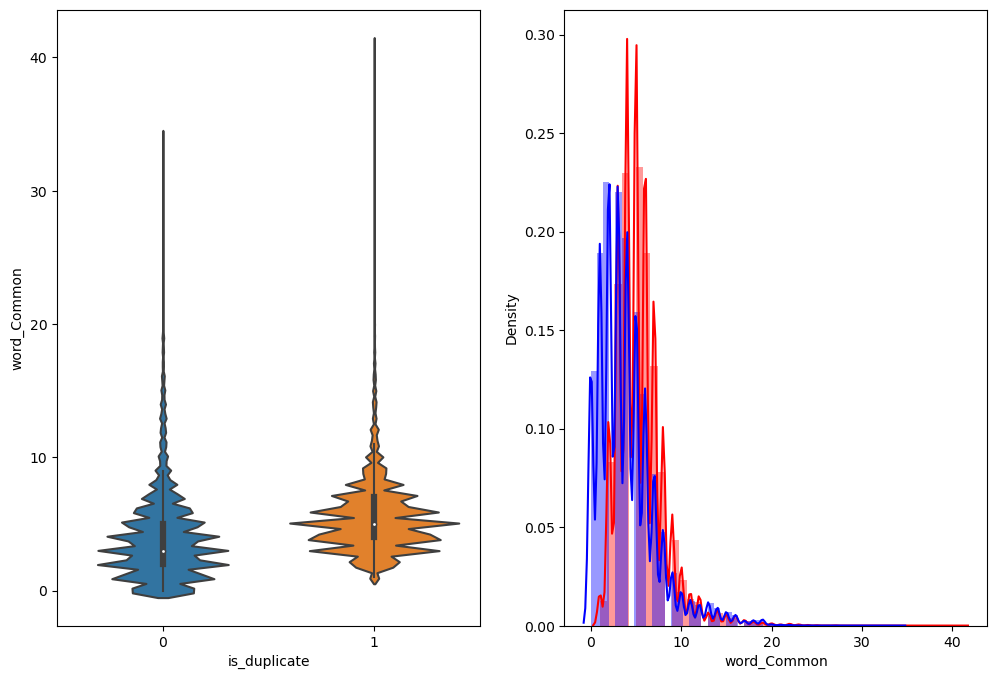

In [24]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_Common',data=df)

plt.subplot(1,2,2)
sns.distplot(df[df["is_duplicate"]==1.0]["word_Common"],label="1",color="red")
sns.distplot(df[df["is_duplicate"]==0.0]["word_Common"],label="0",color="blue")

- the distribution is overlapping,not a good feature to distinguish